# Introduction/Purpose

The most common cancer in the United States is skin cancer, with a prevalence of 20% by the age of 70. Early detection is essential for prompt treatment and survival. A model to predict malignant skin cancer from at-home images can accelerate the process of seeking medical support.

### Import Libraries

In [32]:
# Standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch/torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Load + Wrangle Data

In [2]:
# Image preprocessing; resize to 224 x 224 pixels, convert image to PyTorch tensor, normalize pixel values

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

##### Load first image dataset

In [3]:
# Load data, assign labels from folder names, transform images

data_dir = './Malignant_vs_Benign_Skin_Cancer/Data - Unsplit'

dataset1 = datasets.ImageFolder(root=data_dir, transform=transform)

In [4]:
# Split into train and test sets

val_split = 0.2
total_size = len(dataset1)
val_size = int(val_split * total_size)
train_size = total_size - val_size

torch.manual_seed(42) 
train_dataset1, val_dataset1 = random_split(dataset1, [train_size, val_size])

##### Load second image dataset

In [5]:
# Map labels from .csv file to images

from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomImageDataset(Dataset):
    # Initialize dataset
    def __init__(self, img_dir, label_file, transform=transform):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(label_file)
        self.labels_df.columns = self.labels_df.columns.str.strip().str.lower()

    # Number of samples in dataset
    def __len__(self):
        return len(self.labels_df)

    # Returns one image/label at a time; required by all PyTorch Dataset objects
    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'] + '.jpg')

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        
        temp_label = row['dx'] 
        if temp_label in ['akiec', 'bcc', 'mel']:
            label = 1
        else:
            label = 0

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create dataset labels

dataset2 = CustomImageDataset(
    img_dir=r'.\Skin Cancer MNIST HAM10000\Images', 
    label_file=r'.\Skin Cancer MNIST HAM10000\Original Data\HAM10000_metadata.csv', 
    transform=transform
)

In [7]:
# Split into train and test sets

val_split = 0.2
total_size = len(dataset2)
val_size = int(val_split * total_size)
train_size = total_size - val_size

torch.manual_seed(42) 
train_dataset2, val_dataset2 = random_split(dataset2, [train_size, val_size])

##### Concatenate datasets, create DataLoaders

In [8]:
# Concatenate datasets

from torch.utils.data import ConcatDataset

merged_train_dataset = ConcatDataset([train_dataset1, train_dataset2])
merged_val_dataset = ConcatDataset([val_dataset1, val_dataset2])

In [9]:
# Create DataLoaders to feed data into model during training

train_loader = DataLoader(merged_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(merged_val_dataset, batch_size=32, shuffle=False)

### EDA

*Are the classes balanced?*

Dataset 1:
Benign: 1800 images
Malignant: 1497 images
Approximately balanced

Dataset 2:


In [10]:
labels_df = pd.read_csv(r'.\Skin Cancer MNIST HAM10000\Original Data\HAM10000_metadata.csv')

In [11]:
labels_df.columns = labels_df.columns.str.strip().str.lower()

In [12]:
labels_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [13]:
malignant_labels = ['akiec', 'bcc', 'mel']

In [14]:
# Count images
malignant_count = labels_df['dx'].isin(malignant_labels).sum()
benign_count = len(labels_df) - malignant_count

print(f"Malignant images: {malignant_count}")
print(f"Benign images: {benign_count}")

Malignant images: 1954
Benign images: 8061


In [15]:
print(f"Malignant %: {(malignant_count/(malignant_count+benign_count))*100:.2f}%")

Malignant %: 19.51%


Class imbalance in 2nd dataset

In [16]:
print(f"Malignant % in combined dataset: {((1497+malignant_count)/(1800+1497+malignant_count+benign_count))*100:.2f}%")

Malignant % in combined dataset: 25.92%


Mild class imbalance in overall dataset; to be accounted for in upcoming steps

[Class imbalance % criteria](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets)

*Do the images contain enough variety?*


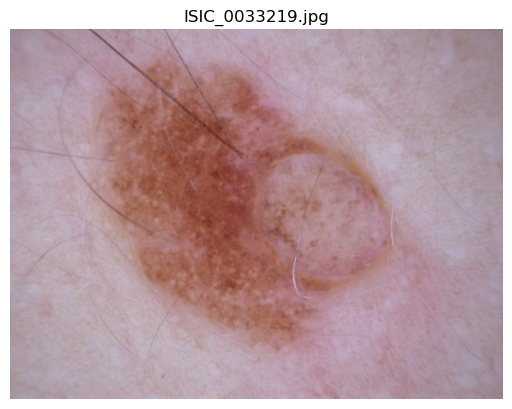

In [17]:
import random

image_files = labels_df['image_id']

random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)

# Display random image
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

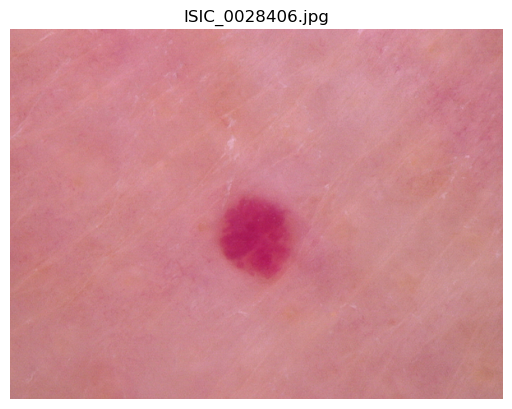

In [18]:
random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

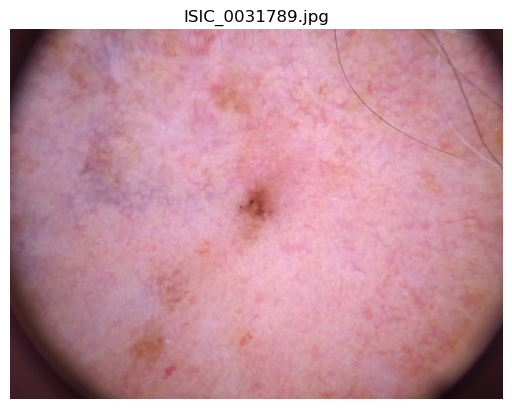

In [19]:
random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

Both datasets show wide variety in shape, color, and appearance/no appearance of hair. However, there is less variety in skin tone and the model may not generalize well to those with darker skin tones.

*Image formats and resolutions*

Images resized in Data Wrangling step; all images are .jpg

### Pre-Processing

Resizing, normalizing, tensor conversion performed in previous steps; data augmentation not needed due to large size of dataset

### Modeling

In [20]:
# Define the CNN

In [21]:
# Define a neural network class from nn.Module
class Net(nn.Module):
    # Initialize neural network
    def __init__(self):
        super().__init__()
        # Define convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Define max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Define 2nd convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Define fully connected layers
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    # Define how data flows through network
    def forward(self, x):
        # ReLU activation + max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten tensor into 1D vector, keeping batch dimension intact
        x = torch.flatten(x, 1) 
        # Apply ReLU activation to fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # No activation for final layer
        x = self.fc3(x)
        x = x.squeeze(1)
        return x

# Instantiate model
net = Net()

In [22]:
# Define a loss function and optimizer

In [23]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
# Train the network

In [25]:
print(transform)
print("Type:", type(transform))
print("Internal transforms:")
for idx, t in enumerate(transform.transforms):
    print(f" {idx}: {t}, type: {type(t)}")

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Type: <class 'torchvision.transforms.transforms.Compose'>
Internal transforms:
 0: Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True), type: <class 'torchvision.transforms.transforms.Resize'>
 1: ToTensor(), type: <class 'torchvision.transforms.transforms.ToTensor'>
 2: Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), type: <class 'torchvision.transforms.transforms.Normalize'>


In [27]:
# loop over the dataset 2 times
for epoch in range(2):  

    # Initialize running loss
    running_loss = 0.0

    # Loop over training data
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Ensure labels are floats
        labels = labels.float()

        # Reset the parameter gradients to prevent accumulation from previous batches
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs) # Pass inputs through network, generates predictions for each image
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backpropagation to compute gradients for each parameter in the network based on the loss
        optimizer.step() # Apply gradient updates to improve the model's parameters

        # Print statistics
        running_loss += loss.item() # Accumulates loss
        if i % 2000 == 1999:    # print avg loss every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [28]:
# Save trained model
PATH = './skin_cancer.pth'
torch.save(net.state_dict(), PATH)

In [29]:
# Test the network

TypeError: Invalid shape (3, 906, 1810) for image data

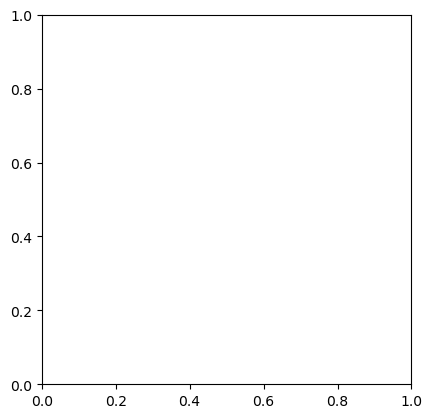

In [33]:
dataiter = iter(val_loader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = net(images)


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
# Evaluate performance on entire dataset

In [ ]:
print(classification_report(labels.cpu(), predicted.cpu()))

In [ ]:
# Train on GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
net.to(device)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)